In [ ]:
!pip install scipy --upgrade

### imports

In [1]:
import scipy.io
import numpy as np
from tqdm.auto import tqdm
from functools import partial
from google.colab import drive
import matplotlib.pyplot as plt
from itertools import combinations

# pytorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tqdm = partial(tqdm, position=0, leave=False)
print(device)

cpu


In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/WorkSpace

Mounted at /content/drive
/content/drive/MyDrive/Thesis/WorkSpace


In [3]:
from modules import data_f, network_f, network_architectures, preprocess_f

### load the data from mat file

In [46]:
mat = scipy.io.loadmat('datasets/DREAMER.mat', simplify_cells=True)
data = mat['DREAMER']['Data']
score_types = ['ScoreValence', 'ScoreArousal', 'ScoreDominance']

### interpolate the signals to be of equal length

In [47]:
#person1 = data[0]

inputs = []
labels = []
for person in tqdm(data):
  scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
  # scores -= 1  # [1,5] -> [0,4]
  scores = np.where(scores>=2.5, 1, 0).astype(float)  # [1,5] -> 0/1 

  person_signals = []
  for vid in range(18):
    signal_vals = []
    for signal_type in ['EEG', 'ECG']:
      for signal_mode in ['baseline', 'stimuli']:
        signal = person[signal_type][signal_mode][vid]
        for channel in np.swapaxes(signal,0,1):
          ch_interp = np.interp(np.linspace(0,len(channel)-1,500), range(len(channel)), channel)
          signal_vals.append(ch_interp)
    person_signals.append(signal_vals)

  inputs.append(person_signals)
  labels.append(scores)  


inputs = np.array(inputs)
labels = np.array(labels)
print(inputs.shape)
print(labels.shape, np.unique(labels))
data = inputs, labels



# normalize the signals to be in range(-1,1)
preprocess_f.normalize(inputs)
pass

  0%|          | 0/23 [00:00<?, ?it/s]

(23, 18, 32, 500)
(23, 18, 3) [0. 1.]


## Using full dataset

In [ ]:
inputs, labels = data
inputs = inputs.reshape(-1, *inputs.shape[2:])
labels = labels.reshape(-1, *labels.shape[2:])

### create dataloader

In [ ]:
dataloaders = data_f.create_trainValLoaders(inputs, labels, test_size=.25, batch_size=32)

### define the network

view network summary

In [ ]:
model = network_architectures.Conv_Classifier(num_classes=3, inp_channels=32)
model = model.to(device)

summary(model, (32,32768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 8190]          24,640
              ReLU-2             [-1, 64, 8190]               0
         MaxPool1d-3             [-1, 64, 2048]               0
            Conv1d-4             [-1, 192, 512]          49,344
              ReLU-5             [-1, 192, 512]               0
         MaxPool1d-6             [-1, 192, 128]               0
            Conv1d-7             [-1, 384, 128]         221,568
              ReLU-8             [-1, 384, 128]               0
            Conv1d-9             [-1, 256, 128]         295,168
             ReLU-10             [-1, 256, 128]               0
           Conv1d-11             [-1, 256, 128]         196,864
             ReLU-12             [-1, 256, 128]               0
        MaxPool1d-13              [-1, 256, 32]               0
AdaptiveAvgPool1d-14               [-1,

set criterion and optimizer

In [ ]:
# Define a Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### train the network

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.360, val loss: 1.179  | avg train loss: 0.483, avg val loss: 0.798
epoch: 40  | train loss: 0.262, val loss: 1.622  | avg train loss: 0.312, avg val loss: 1.440
epoch: 60  | train loss: 0.207, val loss: 2.152  | avg train loss: 0.235, avg val loss: 2.042
epoch: 80  | train loss: 0.096, val loss: 2.866  | avg train loss: 0.106, avg val loss: 2.938
epoch: 100  | train loss: 0.007, val loss: 4.365  | avg train loss: 0.037, avg val loss: 3.524
epoch: 120  | train loss: 0.000, val loss: 7.552  | avg train loss: 0.026, avg val loss: 4.611
epoch: 140  | train loss: 0.004, val loss: 4.553  | avg train loss: 0.032, avg val loss: 4.485
epoch: 160  | train loss: 0.005, val loss: 5.008  | avg train loss: 0.020, avg val loss: 4.585
epoch: 180  | train loss: 0.034, val loss: 3.596  | avg train loss: 0.058, avg val loss: 3.374
epoch: 200  | train loss: 0.006, val loss: 4.516  | avg train loss: 0.028, avg val loss: 4.096
Finished Training


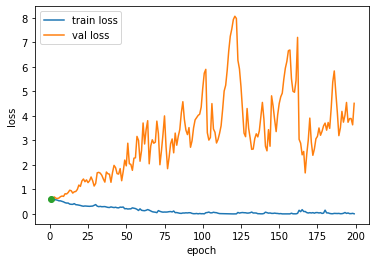

In [ ]:
model.apply(network_f.weight_reset)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=200, verbose=2)

In [ ]:
# model.load_state_dict(best_params)

### evaluate

In [ ]:
print("evaluation results on train data")
lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['train'], predict_fn='threshold')
lbl_true, lbl_pred = [list(lbl) for lbl in lbl_true], [list(lbl) for lbl in lbl_pred]
print(classification_report(lbl_true, lbl_pred, target_names=score_types, zero_division=0))


print("evaluation results on validation data")
lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['val'], predict_fn='threshold')
lbl_true, lbl_pred = [list(lbl) for lbl in lbl_true], [list(lbl) for lbl in lbl_pred]
print(classification_report(lbl_true, lbl_pred, target_names=score_types, zero_division=0))

evaluation results on train data
                precision    recall  f1-score   support

  ScoreValence       1.00      0.99      1.00       184
  ScoreArousal       1.00      1.00      1.00       232
ScoreDominance       1.00      1.00      1.00       246

     micro avg       1.00      1.00      1.00       662
     macro avg       1.00      1.00      1.00       662
  weighted avg       1.00      1.00      1.00       662
   samples avg       0.96      0.96      0.96       662

evaluation results on validation data
                precision    recall  f1-score   support

  ScoreValence       0.67      0.49      0.57        69
  ScoreArousal       0.62      0.79      0.70        68
ScoreDominance       0.71      0.82      0.76        73

     micro avg       0.66      0.70      0.68       210
     macro avg       0.66      0.70      0.67       210
  weighted avg       0.67      0.70      0.68       210
   samples avg       0.66      0.66      0.61       210



## Leave one out cross validation on groups

as mentioned in the dataset: https://ieeexplore.ieee.org/document/7887697

In [28]:
def reset_results():
  results = dict.fromkeys(score_types)
  for score_type in results:
    results[score_type] = {'Accuracy':[], 'F1 Score':[]}
  return results  

def print_scores(results):
  for metric in ['Accuracy', 'F1 Score']:
    print(metric)
    for score_type in score_types:
      print(f'{score_type} : {np.mean(results[score_type][metric]):.4f}')
    print()

### using conv neural net

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.220, val loss: 0.000  | avg train loss: 0.495, avg val loss: 0.099
epoch: 40  | train loss: 0.136, val loss: 11.861  | avg train loss: 0.198, avg val loss: 0.623
epoch: 60  | train loss: 0.068, val loss: 0.000  | avg train loss: 0.113, avg val loss: 0.591
epoch: 80  | train loss: 0.097, val loss: 2.860  | avg train loss: 0.388, avg val loss: 2.348
epoch: 100  | train loss: 0.028, val loss: 2.981  | avg train loss: 0.084, avg val loss: 4.831
epoch: 120  | train loss: 0.256, val loss: 1.280  | avg train loss: 0.328, avg val loss: 3.448
epoch: 140  | train loss: 0.089, val loss: 78.472  | avg train loss: 0.123, avg val loss: 14.836
epoch: 160  | train loss: 0.502, val loss: 1.216  | avg train loss: 0.401, avg val loss: 23.014
epoch: 180  | train loss: 0.439, val loss: 0.676  | avg train loss: 0.508, avg val loss: 2.208
epoch: 200  | train loss: 0.223, val loss: 0.806  | avg train loss: 0.376, avg val loss: 3.348
Finished Training


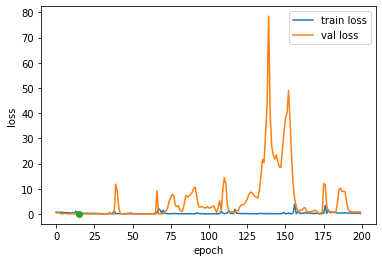

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.419, val loss: 0.570  | avg train loss: 0.530, avg val loss: 0.763
epoch: 40  | train loss: 0.079, val loss: 0.000  | avg train loss: 0.259, avg val loss: 1.638
epoch: 60  | train loss: 1.390, val loss: 0.000  | avg train loss: 0.162, avg val loss: 1.741
epoch: 80  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.076, avg val loss: 0.252
epoch: 100  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 120  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 140  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 160  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 180  | train loss: 0.371, val loss: 0.205  | avg train loss: 0.435, avg val loss: 5.777
epoch: 200  | train loss: 0.058, val loss: 0.717  | avg train loss: 0.172, avg val loss: 0.534
Finished Training


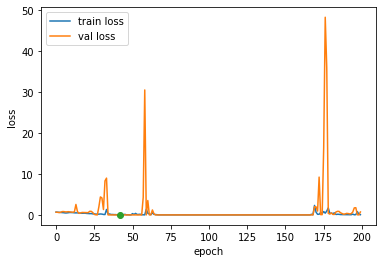

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.260, val loss: 0.417  | avg train loss: 0.474, avg val loss: 0.656
epoch: 40  | train loss: 0.445, val loss: 0.618  | avg train loss: 0.385, avg val loss: 0.772
epoch: 60  | train loss: 0.013, val loss: 1.661  | avg train loss: 0.169, avg val loss: 0.561
epoch: 80  | train loss: 1.346, val loss: 0.003  | avg train loss: 0.292, avg val loss: 0.760
epoch: 100  | train loss: 0.153, val loss: 0.731  | avg train loss: 0.297, avg val loss: 1.579
epoch: 120  | train loss: 0.093, val loss: 0.724  | avg train loss: 0.252, avg val loss: 0.927
epoch: 140  | train loss: 0.018, val loss: 1.115  | avg train loss: 0.103, avg val loss: 1.119
epoch: 160  | train loss: 0.000, val loss: 4.215  | avg train loss: 0.004, avg val loss: 3.351
epoch: 180  | train loss: 0.000, val loss: 5.065  | avg train loss: 0.000, avg val loss: 4.801
epoch: 200  | train loss: 0.000, val loss: 6.666  | avg train loss: 0.000, avg val loss: 5.746
Finished Training


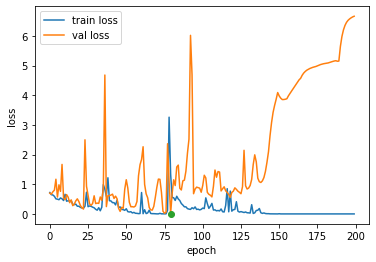

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.319, val loss: 0.266  | avg train loss: 0.471, avg val loss: 0.557
epoch: 40  | train loss: 0.352, val loss: 0.710  | avg train loss: 0.289, avg val loss: 0.353
epoch: 60  | train loss: 0.351, val loss: 0.291  | avg train loss: 0.433, avg val loss: 0.415
epoch: 80  | train loss: 0.160, val loss: 0.025  | avg train loss: 0.296, avg val loss: 0.396
epoch: 100  | train loss: 0.111, val loss: 0.001  | avg train loss: 0.191, avg val loss: 0.136
epoch: 120  | train loss: 1.244, val loss: 0.162  | avg train loss: 0.515, avg val loss: 0.128
epoch: 140  | train loss: 0.244, val loss: 0.091  | avg train loss: 0.322, avg val loss: 0.536
epoch: 160  | train loss: 0.010, val loss: 0.003  | avg train loss: 0.105, avg val loss: 0.218
epoch: 180  | train loss: 0.092, val loss: 0.817  | avg train loss: 0.463, avg val loss: 0.585
epoch: 200  | train loss: 0.217, val loss: 4.280  | avg train loss: 0.103, avg val loss: 1.500
Finished Training


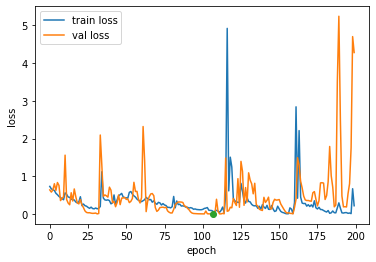

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.501, val loss: 0.740  | avg train loss: 0.606, avg val loss: 1.266
epoch: 40  | train loss: 0.627, val loss: 0.062  | avg train loss: 0.416, avg val loss: 0.558
epoch: 60  | train loss: 0.034, val loss: 14.974  | avg train loss: 0.165, avg val loss: 9.816
epoch: 80  | train loss: 0.046, val loss: 49.010  | avg train loss: 0.207, avg val loss: 32.241
epoch: 100  | train loss: 0.080, val loss: 190.206  | avg train loss: 0.113, avg val loss: 125.866
epoch: 120  | train loss: 0.104, val loss: 0.015  | avg train loss: 0.260, avg val loss: 138.507
epoch: 140  | train loss: 0.005, val loss: 0.090  | avg train loss: 0.030, avg val loss: 0.075
epoch: 160  | train loss: 0.117, val loss: 0.230  | avg train loss: 0.303, avg val loss: 0.151
epoch: 180  | train loss: 0.045, val loss: 0.045  | avg train loss: 0.240, avg val loss: 0.088
epoch: 200  | train loss: 0.020, val loss: 0.040  | avg train loss: 0.086, avg val loss: 0.074
Finished Training


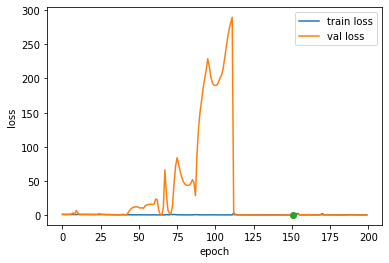

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.256, val loss: 0.476  | avg train loss: 0.477, avg val loss: 0.927
epoch: 40  | train loss: 0.103, val loss: 3.582  | avg train loss: 0.194, avg val loss: 0.565
epoch: 60  | train loss: 0.035, val loss: 3.882  | avg train loss: 0.205, avg val loss: 0.645
epoch: 80  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.005, avg val loss: 0.133
epoch: 100  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 120  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 140  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 160  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 180  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
epoch: 200  | train loss: 0.000, val loss: 0.000  | avg train loss: 0.000, avg val loss: 0.000
Finished Training


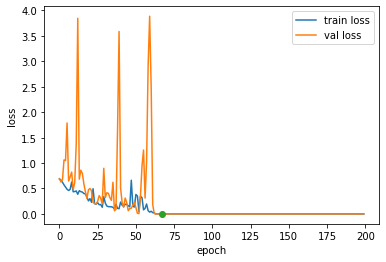

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.310, val loss: 0.129  | avg train loss: 0.470, avg val loss: 0.727
epoch: 40  | train loss: 0.114, val loss: 4.083  | avg train loss: 0.185, avg val loss: 1.934
epoch: 60  | train loss: 0.092, val loss: 1.100  | avg train loss: 0.170, avg val loss: 2.808
epoch: 80  | train loss: 0.055, val loss: 15.268  | avg train loss: 0.375, avg val loss: 4.688
epoch: 100  | train loss: 0.126, val loss: 8.123  | avg train loss: 0.275, avg val loss: 8.041
epoch: 120  | train loss: 0.008, val loss: 2.912  | avg train loss: 0.165, avg val loss: 3.747
epoch: 140  | train loss: 0.002, val loss: 3.080  | avg train loss: 0.002, avg val loss: 3.053
epoch: 160  | train loss: 0.000, val loss: 3.212  | avg train loss: 0.000, avg val loss: 3.209
epoch: 180  | train loss: 0.000, val loss: 3.358  | avg train loss: 0.000, avg val loss: 3.340
epoch: 200  | train loss: 0.000, val loss: 3.342  | avg train loss: 0.000, avg val loss: 3.343
Finished Training


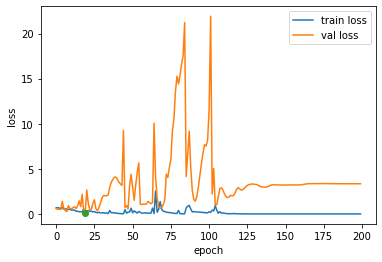

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.453, val loss: 2.135  | avg train loss: 0.478, avg val loss: 1.294
epoch: 40  | train loss: 0.182, val loss: 0.000  | avg train loss: 0.174, avg val loss: 0.349
epoch: 60  | train loss: 0.023, val loss: 3.280  | avg train loss: 0.293, avg val loss: 4.293
epoch: 80  | train loss: 0.000, val loss: 15.579  | avg train loss: 0.004, avg val loss: 13.872
epoch: 100  | train loss: 0.000, val loss: 15.633  | avg train loss: 0.000, avg val loss: 15.603
epoch: 120  | train loss: 0.000, val loss: 15.730  | avg train loss: 0.000, avg val loss: 15.656
epoch: 140  | train loss: 0.000, val loss: 15.712  | avg train loss: 0.000, avg val loss: 15.732
epoch: 160  | train loss: 0.000, val loss: 15.806  | avg train loss: 0.000, avg val loss: 15.726
epoch: 180  | train loss: 0.000, val loss: 15.649  | avg train loss: 0.000, avg val loss: 15.860
epoch: 200  | train loss: 0.000, val loss: 15.733  | avg train loss: 0.000, avg val loss: 15.660
Finished Training


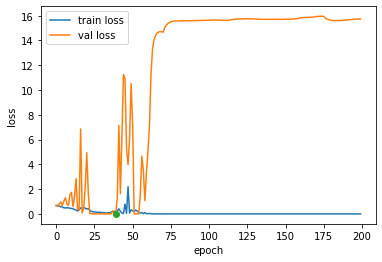

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.376, val loss: 0.612  | avg train loss: 0.531, avg val loss: 0.937
epoch: 40  | train loss: 0.197, val loss: 2.991  | avg train loss: 0.257, avg val loss: 1.482
epoch: 60  | train loss: 0.231, val loss: 2.917  | avg train loss: 0.288, avg val loss: 5.741
epoch: 80  | train loss: 0.244, val loss: 0.219  | avg train loss: 0.179, avg val loss: 6.191
epoch: 100  | train loss: 0.089, val loss: 0.215  | avg train loss: 0.133, avg val loss: 0.233
epoch: 120  | train loss: 0.028, val loss: 3.307  | avg train loss: 0.241, avg val loss: 1.401
epoch: 140  | train loss: 0.088, val loss: 13.871  | avg train loss: 0.569, avg val loss: 5.527
epoch: 160  | train loss: 0.450, val loss: 0.672  | avg train loss: 0.885, avg val loss: 17.026
epoch: 180  | train loss: 0.057, val loss: 3.398  | avg train loss: 0.197, avg val loss: 1.326
epoch: 200  | train loss: 0.020, val loss: 4.406  | avg train loss: 0.111, avg val loss: 2.125
Finished Training


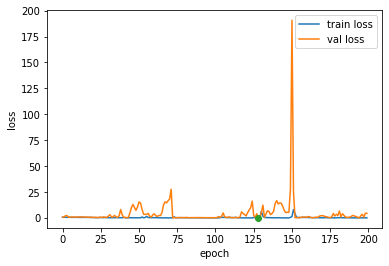

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.400, val loss: 0.831  | avg train loss: 0.509, avg val loss: 0.964
epoch: 40  | train loss: 0.488, val loss: 1.579  | avg train loss: 0.331, avg val loss: 3.841
epoch: 60  | train loss: 0.251, val loss: 3.268  | avg train loss: 0.275, avg val loss: 1.335
epoch: 80  | train loss: 0.076, val loss: 9.303  | avg train loss: 0.195, avg val loss: 2.939
epoch: 100  | train loss: 0.060, val loss: 5.756  | avg train loss: 0.212, avg val loss: 4.377
epoch: 120  | train loss: 0.128, val loss: 4.571  | avg train loss: 0.522, avg val loss: 5.823
epoch: 140  | train loss: 0.038, val loss: 4.640  | avg train loss: 0.042, avg val loss: 3.859
epoch: 160  | train loss: 0.473, val loss: 2.772  | avg train loss: 0.036, avg val loss: 5.178
epoch: 180  | train loss: 0.031, val loss: 1.052  | avg train loss: 0.069, avg val loss: 2.135
epoch: 200  | train loss: 0.009, val loss: 2.330  | avg train loss: 0.055, avg val loss: 1.820
Finished Training


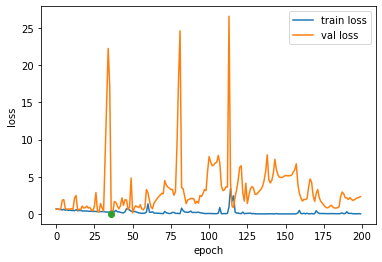

Accuracy
ScoreValence : 0.5500
ScoreArousal : 0.5500
ScoreDominance : 0.4500

F1 Score
ScoreValence : 0.5667
ScoreArousal : 0.5667
ScoreDominance : 0.3667



In [ ]:
results = reset_results()
for person in tqdm(zip(*data), total=len(data[0])):

  inputs, labels = person

  # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
  groups = np.random.choice(range(18), (8,2), replace=False)
  single_groups = [[i] for i in range(18) if i not in groups]
  groups = [list(group) for group in groups] + single_groups

  for test_group in tqdm(groups):
    train_groups = [group for group in groups if group!=test_group]
    train_groups = np.hstack(train_groups)
    
    train_inputs, train_labels = inputs[train_groups], labels[train_groups]
    test_inputs, test_labels = inputs[test_group], labels[test_group]


    # split data into train and val and then create loaders
    dataloaders = data_f.create_trainValLoaders(train_inputs, train_labels, test_size=1, batch_size=4)
    # just use train data without split
    # dataloaders= {'train' : data_f.createLoader(train_inputs, train_labels, batch_size=2, shuffle=True)}
    dataloaders['test'] = data_f.createLoader(test_inputs, test_labels, batch_size=2)

    model = network_architectures.AlexNet(num_classes=3, inp_channels=32)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=200, verbose=2)
    model.load_state_dict(best_params)

    lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['test'], predict_fn='threshold')
    lbl_true, lbl_pred = list(zip(*lbl_true)), list(zip(*lbl_pred))

    for score_indx, score_type in enumerate(score_types):
      results[score_type]['F1 Score'].append(f1_score(lbl_true[score_indx], lbl_pred[score_indx], zero_division=0))
      results[score_type]['Accuracy'].append(accuracy_score(lbl_true[score_indx], lbl_pred[score_indx]))
  
  print_scores(results)
  break

In [ ]:
print_scores(results)

Accuracy
ScoreValence : 0.5500
ScoreArousal : 0.5500
ScoreDominance : 0.4500

F1 Score
ScoreValence : 0.5667
ScoreArousal : 0.5667
ScoreDominance : 0.3667



### using LSTM

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.006, val loss: 2.118  | avg train loss: 0.138, avg val loss: 1.586
epoch: 40  | train loss: 0.001, val loss: 2.674  | avg train loss: 0.003, avg val loss: 2.446
epoch: 60  | train loss: 0.001, val loss: 2.988  | avg train loss: 0.001, avg val loss: 2.846
epoch: 80  | train loss: 0.000, val loss: 3.201  | avg train loss: 0.000, avg val loss: 3.104
epoch: 100  | train loss: 0.000, val loss: 3.384  | avg train loss: 0.000, avg val loss: 3.301
epoch: 120  | train loss: 0.000, val loss: 3.537  | avg train loss: 0.000, avg val loss: 3.468
epoch: 140  | train loss: 0.000, val loss: 3.668  | avg train loss: 0.000, avg val loss: 3.607
epoch: 160  | train loss: 0.000, val loss: 3.778  | avg train loss: 0.000, avg val loss: 3.728
epoch: 180  | train loss: 0.000, val loss: 3.878  | avg train loss: 0.000, avg val loss: 3.830
epoch: 200  | train loss: 0.000, val loss: 3.970  | avg train loss: 0.000, avg val loss: 3.927
Finished Training


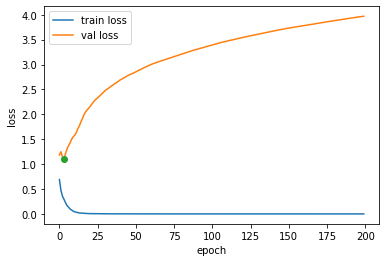

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.008, val loss: 3.855  | avg train loss: 0.144, avg val loss: 2.425
epoch: 40  | train loss: 0.002, val loss: 5.184  | avg train loss: 0.003, avg val loss: 4.635
epoch: 60  | train loss: 0.001, val loss: 5.946  | avg train loss: 0.001, avg val loss: 5.603
epoch: 80  | train loss: 0.000, val loss: 6.517  | avg train loss: 0.000, avg val loss: 6.257
epoch: 100  | train loss: 0.000, val loss: 6.977  | avg train loss: 0.000, avg val loss: 6.762
epoch: 120  | train loss: 0.000, val loss: 7.358  | avg train loss: 0.000, avg val loss: 7.181
epoch: 140  | train loss: 0.000, val loss: 7.693  | avg train loss: 0.000, avg val loss: 7.538
epoch: 160  | train loss: 0.000, val loss: 7.989  | avg train loss: 0.000, avg val loss: 7.851
epoch: 180  | train loss: 0.000, val loss: 8.263  | avg train loss: 0.000, avg val loss: 8.134
epoch: 200  | train loss: 0.000, val loss: 8.499  | avg train loss: 0.000, avg val loss: 8.390
Finished Training


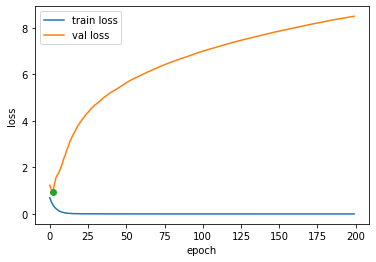

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.007, val loss: 3.754  | avg train loss: 0.137, avg val loss: 2.146
epoch: 40  | train loss: 0.001, val loss: 5.624  | avg train loss: 0.003, avg val loss: 4.857
epoch: 60  | train loss: 0.001, val loss: 6.714  | avg train loss: 0.001, avg val loss: 6.222
epoch: 80  | train loss: 0.000, val loss: 7.504  | avg train loss: 0.000, avg val loss: 7.143
epoch: 100  | train loss: 0.000, val loss: 8.131  | avg train loss: 0.000, avg val loss: 7.845
epoch: 120  | train loss: 0.000, val loss: 8.632  | avg train loss: 0.000, avg val loss: 8.399
epoch: 140  | train loss: 0.000, val loss: 9.077  | avg train loss: 0.000, avg val loss: 8.871
epoch: 160  | train loss: 0.000, val loss: 9.447  | avg train loss: 0.000, avg val loss: 9.274
epoch: 180  | train loss: 0.000, val loss: 9.779  | avg train loss: 0.000, avg val loss: 9.622
epoch: 200  | train loss: 0.000, val loss: 10.064  | avg train loss: 0.000, avg val loss: 9.931
Finished Training


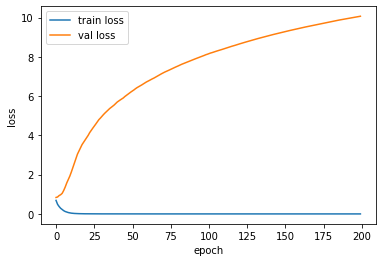

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.011, val loss: 2.628  | avg train loss: 0.180, avg val loss: 1.725
epoch: 40  | train loss: 0.002, val loss: 3.590  | avg train loss: 0.004, avg val loss: 3.193
epoch: 60  | train loss: 0.001, val loss: 4.154  | avg train loss: 0.001, avg val loss: 3.915
epoch: 80  | train loss: 0.000, val loss: 4.554  | avg train loss: 0.000, avg val loss: 4.370
epoch: 100  | train loss: 0.000, val loss: 4.889  | avg train loss: 0.000, avg val loss: 4.730
epoch: 120  | train loss: 0.000, val loss: 5.150  | avg train loss: 0.000, avg val loss: 5.030
epoch: 140  | train loss: 0.000, val loss: 5.380  | avg train loss: 0.000, avg val loss: 5.274
epoch: 160  | train loss: 0.000, val loss: 5.580  | avg train loss: 0.000, avg val loss: 5.486
epoch: 180  | train loss: 0.000, val loss: 5.761  | avg train loss: 0.000, avg val loss: 5.676
epoch: 200  | train loss: 0.000, val loss: 5.924  | avg train loss: 0.000, avg val loss: 5.849
Finished Training


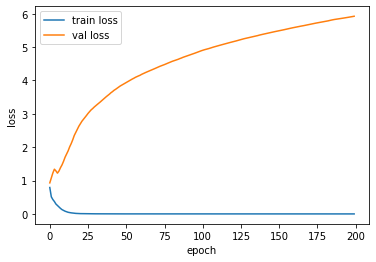

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.010, val loss: 2.386  | avg train loss: 0.153, avg val loss: 1.654
epoch: 40  | train loss: 0.002, val loss: 3.216  | avg train loss: 0.004, avg val loss: 2.901
epoch: 60  | train loss: 0.001, val loss: 3.650  | avg train loss: 0.001, avg val loss: 3.469
epoch: 80  | train loss: 0.000, val loss: 3.956  | avg train loss: 0.001, avg val loss: 3.824
epoch: 100  | train loss: 0.000, val loss: 4.179  | avg train loss: 0.000, avg val loss: 4.075
epoch: 120  | train loss: 0.000, val loss: 4.378  | avg train loss: 0.000, avg val loss: 4.292
epoch: 140  | train loss: 0.000, val loss: 4.535  | avg train loss: 0.000, avg val loss: 4.468
epoch: 160  | train loss: 0.000, val loss: 4.668  | avg train loss: 0.000, avg val loss: 4.607
epoch: 180  | train loss: 0.000, val loss: 4.790  | avg train loss: 0.000, avg val loss: 4.731
epoch: 200  | train loss: 0.000, val loss: 4.899  | avg train loss: 0.000, avg val loss: 4.846
Finished Training


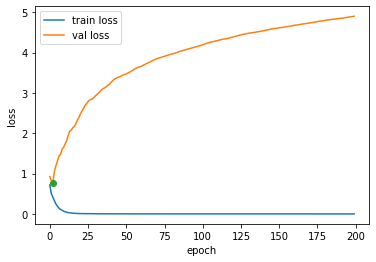

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.004, val loss: 1.580  | avg train loss: 0.125, avg val loss: 1.219
epoch: 40  | train loss: 0.001, val loss: 1.936  | avg train loss: 0.002, avg val loss: 1.786
epoch: 60  | train loss: 0.000, val loss: 2.151  | avg train loss: 0.001, avg val loss: 2.053
epoch: 80  | train loss: 0.000, val loss: 2.309  | avg train loss: 0.000, avg val loss: 2.238
epoch: 100  | train loss: 0.000, val loss: 2.448  | avg train loss: 0.000, avg val loss: 2.385
epoch: 120  | train loss: 0.000, val loss: 2.560  | avg train loss: 0.000, avg val loss: 2.508
epoch: 140  | train loss: 0.000, val loss: 2.661  | avg train loss: 0.000, avg val loss: 2.615
epoch: 160  | train loss: 0.000, val loss: 2.749  | avg train loss: 0.000, avg val loss: 2.708
epoch: 180  | train loss: 0.000, val loss: 2.823  | avg train loss: 0.000, avg val loss: 2.789
epoch: 200  | train loss: 0.000, val loss: 2.895  | avg train loss: 0.000, avg val loss: 2.861
Finished Training


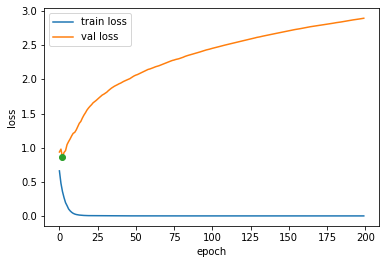

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.005, val loss: 4.595  | avg train loss: 0.139, avg val loss: 2.768
epoch: 40  | train loss: 0.001, val loss: 5.878  | avg train loss: 0.002, avg val loss: 5.370
epoch: 60  | train loss: 0.000, val loss: 6.603  | avg train loss: 0.001, avg val loss: 6.283
epoch: 80  | train loss: 0.000, val loss: 7.081  | avg train loss: 0.000, avg val loss: 6.869
epoch: 100  | train loss: 0.000, val loss: 7.449  | avg train loss: 0.000, avg val loss: 7.281
epoch: 120  | train loss: 0.000, val loss: 7.760  | avg train loss: 0.000, avg val loss: 7.617
epoch: 140  | train loss: 0.000, val loss: 8.019  | avg train loss: 0.000, avg val loss: 7.899
epoch: 160  | train loss: 0.000, val loss: 8.235  | avg train loss: 0.000, avg val loss: 8.135
epoch: 180  | train loss: 0.000, val loss: 8.428  | avg train loss: 0.000, avg val loss: 8.338
epoch: 200  | train loss: 0.000, val loss: 8.601  | avg train loss: 0.000, avg val loss: 8.521
Finished Training


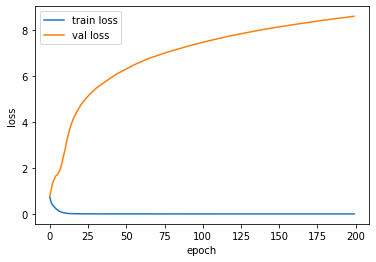

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.008, val loss: 8.647  | avg train loss: 0.168, avg val loss: 5.194
epoch: 40  | train loss: 0.001, val loss: 10.972  | avg train loss: 0.003, avg val loss: 10.092
epoch: 60  | train loss: 0.001, val loss: 11.949  | avg train loss: 0.001, avg val loss: 11.532
epoch: 80  | train loss: 0.000, val loss: 12.567  | avg train loss: 0.000, avg val loss: 12.292
epoch: 100  | train loss: 0.000, val loss: 13.017  | avg train loss: 0.000, avg val loss: 12.814
epoch: 120  | train loss: 0.000, val loss: 13.365  | avg train loss: 0.000, avg val loss: 13.204
epoch: 140  | train loss: 0.000, val loss: 13.643  | avg train loss: 0.000, avg val loss: 13.515
epoch: 160  | train loss: 0.000, val loss: 13.884  | avg train loss: 0.000, avg val loss: 13.774
epoch: 180  | train loss: 0.000, val loss: 14.085  | avg train loss: 0.000, avg val loss: 13.990
epoch: 200  | train loss: 0.000, val loss: 14.265  | avg train loss: 0.000, avg val loss: 14.182
Finished Training


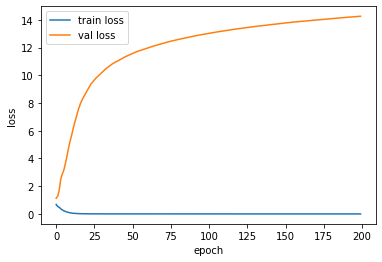

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.011, val loss: 1.977  | avg train loss: 0.157, avg val loss: 1.463
epoch: 40  | train loss: 0.002, val loss: 2.659  | avg train loss: 0.004, avg val loss: 2.377
epoch: 60  | train loss: 0.001, val loss: 3.059  | avg train loss: 0.001, avg val loss: 2.878
epoch: 80  | train loss: 0.000, val loss: 3.353  | avg train loss: 0.001, avg val loss: 3.220
epoch: 100  | train loss: 0.000, val loss: 3.584  | avg train loss: 0.000, avg val loss: 3.476
epoch: 120  | train loss: 0.000, val loss: 3.776  | avg train loss: 0.000, avg val loss: 3.688
epoch: 140  | train loss: 0.000, val loss: 3.945  | avg train loss: 0.000, avg val loss: 3.868
epoch: 160  | train loss: 0.000, val loss: 4.097  | avg train loss: 0.000, avg val loss: 4.027
epoch: 180  | train loss: 0.000, val loss: 4.230  | avg train loss: 0.000, avg val loss: 4.168
epoch: 200  | train loss: 0.000, val loss: 4.355  | avg train loss: 0.000, avg val loss: 4.297
Finished Training


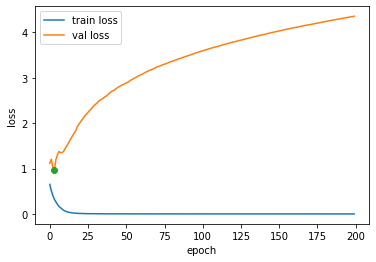

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.008, val loss: 1.879  | avg train loss: 0.157, avg val loss: 1.329
epoch: 40  | train loss: 0.001, val loss: 2.429  | avg train loss: 0.003, avg val loss: 2.199
epoch: 60  | train loss: 0.001, val loss: 2.749  | avg train loss: 0.001, avg val loss: 2.611
epoch: 80  | train loss: 0.000, val loss: 2.997  | avg train loss: 0.000, avg val loss: 2.886
epoch: 100  | train loss: 0.000, val loss: 3.198  | avg train loss: 0.000, avg val loss: 3.106
epoch: 120  | train loss: 0.000, val loss: 3.366  | avg train loss: 0.000, avg val loss: 3.287
epoch: 140  | train loss: 0.000, val loss: 3.513  | avg train loss: 0.000, avg val loss: 3.445
epoch: 160  | train loss: 0.000, val loss: 3.645  | avg train loss: 0.000, avg val loss: 3.584
epoch: 180  | train loss: 0.000, val loss: 3.764  | avg train loss: 0.000, avg val loss: 3.709
epoch: 200  | train loss: 0.000, val loss: 3.874  | avg train loss: 0.000, avg val loss: 3.824
Finished Training


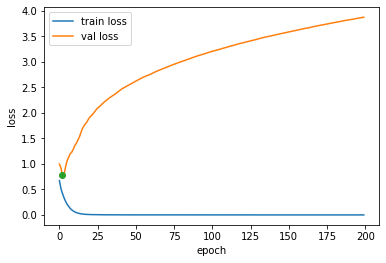

Accuracy
ScoreValence : 0.4500
ScoreArousal : 0.4000
ScoreDominance : 0.5000

F1 Score
ScoreValence : 0.4333
ScoreArousal : 0.3000
ScoreDominance : 0.5667



In [ ]:
results = reset_results()
for person in tqdm(zip(*data), total=len(data[0])):

  inputs, labels = person

  # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
  groups = np.random.choice(range(18), (8,2), replace=False)
  single_groups = [[i] for i in range(18) if i not in groups]
  groups = [list(group) for group in groups] + single_groups

  for test_group in tqdm(groups):
    train_groups = [group for group in groups if group!=test_group]
    train_groups = np.hstack(train_groups)
    
    train_inputs, train_labels = inputs[train_groups], labels[train_groups]
    test_inputs, test_labels = inputs[test_group], labels[test_group]


    # split data into train and val and then create loaders
    dataloaders = data_f.create_trainValLoaders(train_inputs.swapaxes(1,2), train_labels, test_size=1, batch_size=4)
    # just use train data without split
    # dataloaders= {'train' : data_f.createLoader(train_inputs, train_labels, batch_size=2, shuffle=True)}
    dataloaders['test'] = data_f.createLoader(test_inputs.swapaxes(1,2), test_labels, batch_size=2)

    model = network_architectures.MV_LSTM(n_features=32,seq_length=500,n_classes=3)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=200, verbose=2)
    model.load_state_dict(best_params)

    lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['test'], predict_fn='threshold')
    lbl_true, lbl_pred = list(zip(*lbl_true)), list(zip(*lbl_pred))

    for score_indx, score_type in enumerate(score_types):
      results[score_type]['F1 Score'].append(f1_score(lbl_true[score_indx], lbl_pred[score_indx], zero_division=0))
      results[score_type]['Accuracy'].append(accuracy_score(lbl_true[score_indx], lbl_pred[score_indx]))
  
  print_scores(results)
  break

In [ ]:
print_scores(results)

Accuracy
ScoreValence : 0.4500
ScoreArousal : 0.4000
ScoreDominance : 0.5000

F1 Score
ScoreValence : 0.4333
ScoreArousal : 0.3000
ScoreDominance : 0.5667



### using SVM

extract features from input

In [48]:
inputs, labels = data

print(inputs.shape)
inputs = preprocess_f.get_features(inputs, sub_window_size=10, stride_size=10)
print(inputs.shape)

data = inputs, labels

(23, 18, 32, 500)
(23, 18, 64, 50)


In [ ]:
results = reset_results()
for run in tqdm(range(10)):
  for person in tqdm(zip(*data), total=len(data[0])):

    inputs, labels = person

    # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
    groups = np.random.choice(range(18), (8,2), replace=False)
    single_groups = [[i] for i in range(18) if i not in groups]
    groups = [list(group) for group in groups] + single_groups

    for test_group in tqdm(groups):
      train_groups = [group for group in groups if group!=test_group]
      train_groups = np.hstack(train_groups)
      
      train_inputs, train_labels = inputs[train_groups], labels[train_groups]
      test_inputs, test_labels = inputs[test_group], labels[test_group]

      # flatten train and test inputs
      train_inputs = train_inputs.reshape(train_inputs.shape[0],-1)
      test_inputs = test_inputs.reshape(test_inputs.shape[0],-1)

      # train an SVM for each score type
      for score_indx, score_type in enumerate(score_types):
        clf = svm.SVC()
        # clf = svm.LinearSVC()
        n_classes = np.unique(train_labels[:,score_indx])
        if len(n_classes) == 2:
          clf.fit(train_inputs, train_labels[:,score_indx])
          lbl_pred = clf.predict(test_inputs)
        elif len(n_classes) == 1:
          pred_class = n_classes[0]
          lbl_pred = np.full_like(test_labels[:,score_indx], pred_class)

        results[score_type]['F1 Score'].append(f1_score(test_labels[:,score_indx], lbl_pred, zero_division=0))
        results[score_type]['Accuracy'].append(accuracy_score(test_labels[:,score_indx], lbl_pred))  

  print_scores(results)

In [50]:
print_scores(results)

Accuracy
ScoreValence : 0.5970
ScoreArousal : 0.6807
ScoreDominance : 0.7580

F1 Score
ScoreValence : 0.5288
ScoreArousal : 0.7251
ScoreDominance : 0.7710



### using KNN

get features from input

In [ ]:
inputs, labels = data

print(inputs.shape)
inputs = preprocess_f.get_features(inputs, sub_window_size=10, stride_size=10)
print(inputs.shape)

data = inputs, labels

(23, 18, 32, 500)
(23, 18, 64, 50)


In [ ]:
results = reset_results()
for _ in tqdm(range(10)):
  for person in tqdm(zip(*data), total=len(data[0])):

    inputs, labels = person

    # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
    groups = np.random.choice(range(18), (8,2), replace=False)
    single_groups = [[i] for i in range(18) if i not in groups]
    groups = [list(group) for group in groups] + single_groups

    for test_group in tqdm(groups):
      train_groups = [group for group in groups if group!=test_group]
      train_groups = np.hstack(train_groups)
      
      train_inputs, train_labels = inputs[train_groups], labels[train_groups]
      test_inputs, test_labels = inputs[test_group], labels[test_group]

      # flatten train and test inputs
      train_inputs = train_inputs.reshape(train_inputs.shape[0],-1)
      test_inputs = test_inputs.reshape(test_inputs.shape[0],-1)

      neigh = KNeighborsClassifier(n_neighbors=1)
      neigh.fit(train_inputs, train_labels)
      lbl_pred = neigh.predict(test_inputs)

      # train an SVM for each score type
      for score_indx, score_type in enumerate(score_types):
        results[score_type]['F1 Score'].append(f1_score(test_labels[:, score_indx], lbl_pred[:, score_indx], zero_division=0))
        results[score_type]['Accuracy'].append(accuracy_score(test_labels[:, score_indx], lbl_pred[:, score_indx]))

  print_scores(results)

In [52]:
print_scores(results)

Accuracy
ScoreValence : 0.5102
ScoreArousal : 0.6822
ScoreDominance : 0.7202

F1 Score
ScoreValence : 0.4333
ScoreArousal : 0.6707
ScoreDominance : 0.7213

